In [1]:
import os, cv2,  glob, shutil, PIL, PIL.Image, sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from keras import layers, models, Input, optimizers, initializers, regularizers, metrics
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
# 폴더 경로
data_path = r"C:\Users\Administrator\Desktop\Testing DataSet 15"

# 데이터

In [3]:
# 데이터 가져오기
Images, Labels = [], []
img_r, img_c = 224, 224

for data_dir in os.listdir(data_path):
    for dirr in sorted(os.listdir(data_path +"\\" +data_dir)):
        Labels.append(int(data_dir))
        dirr = os.path.join(data_path +"\\" +data_dir, dirr)
        if dirr.endswith('.png'):
            img = cv2.imread(dirr)
            img = cv2.resize(img, (img_r, img_c))
            Images.append(img)

Image = (np.asarray(Images)/255).astype('float32')
Label = np.asarray(Labels)


print(len(Image))
print(len(Label))

3680
3680


In [4]:
# 데이터 나누기 ( 학습, 검증, 테스트 )
no_x_train, x_test, no_y_train, y_test = train_test_split(Image, Label, train_size=0.9, random_state=101, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(no_x_train, no_y_train, train_size=0.8, random_state=101, shuffle=True)

y_train = to_categorical(y_train, 19)
y_val = to_categorical(y_val, 19)
y_test = to_categorical(y_test, 19)

print("x_train : ", len(x_train))
print("y_train : ", len(y_train))
print("x_val : ", len(x_val))
print("y_val : ", len(y_val))
print("x_test : ", len(x_test))
print("y_test : ", len(y_test))

x_train :  2649
y_train :  2649
x_val :  663
y_val :  663
x_test :  368
y_test :  368


In [5]:
# 데이터 확인하기
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [6]:
# 데이터 증강
x_train2 = x_train.tolist()
y_train2 = y_train.tolist()

for img in x_train:
    flipped = tf.image.flip_left_right(img)
    x_train2.append(flipped)

for label in y_train:
    y_train2.append(label)

print("x_train : ", len(x_train2))
print("y_train : ", len(y_train2))


# 데이터 확인

# flipped2 = tf.image.flip_up_down(x_train[0])
# visualize(flipped2, flipped)

# 데이터 변환

x_train = np.asarray(x_train2)
y_train = np.asarray(y_train2)

x_train :  5298
y_train :  5298


In [9]:
# 학습 파라미터
input_size, output_size = 224, 19
learning_rate = 1e-4
optimizer=Adam(learning_rate=learning_rate)
loss='categorical_crossentropy'
activation='softmax'
metrics=['acc']

epochs= 4
batch_size= 16

model_s = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3), classes=output_size)

In [12]:
# 학습할 모델 구조 확인
for layer in model_s.layers:
    layer.trainable = False

# layers 추가
model_model_s = models.Sequential()
model_model_s.add(model_s)
model_model_s.add(layers.Flatten())
model_model_s.add(layers.Dense(512, activation='relu'))
model_model_s.add(layers.Dense(output_size, activation='softmax'))

model_model_s.summary()

model_model_s.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               25690624  
_________________________________________________________________
dense_1 (Dense)              (None, 19)                9747      
Total params: 28,929,235
Trainable params: 25,700,371
Non-trainable params: 3,228,864
_________________________________________________________________


In [14]:
# 모델 학습
history = model_model_s.fit(x_train,y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val))

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/4
332/332 [==============================] - 11s 24ms/step - loss: 0.5302 - acc: 0.8681 - val_loss: 0.1885 - val_acc: 0.9563
Epoch 2/4
332/332 [==============================] - 7s 21ms/step - loss: 0.0530 - acc: 0.9906 - val_loss: 0.1299 - val_acc: 0.9623
Epoch 3/4
332/332 [==============================] - 7s 21ms/step - loss: 0.0276 - acc: 0.9983 - val_loss: 0.0772 - val_acc: 0.9744
Epoch 4/4
332/332 [==============================] - 7s 21ms/step - loss: 0.0241 - acc: 0.9964 - val_loss: 0.0739 - val_acc: 0.9774


In [16]:
#모델 성능 테스트
model_model_s.evaluate(x_test,y_test)

12/12 [==============================] - 1s 27ms/step - loss: 0.1303 - acc: 0.9728


[0.13032932579517365, 0.9728260636329651]

# 실제 휴대폰으로 촬영한 사진으로 테스트

In [17]:
test_data_path = r"C:\Users\Administrator\Desktop\Test Data 15"

In [18]:
image_test = []
img_list = []
title_list = []

for dirr in sorted(os.listdir(test_data_path)):
    dirr = os.path.join(test_data_path +"\\", dirr)
    img_list.append(dirr.split('\\')[-1])
    if dirr.endswith('.jpg'):
        img = cv2.imread(dirr)
        img = cv2.resize(img, (img_r, img_c))
        image_test.append(img)
#             Images.append(img)

image_test2 = (np.asarray(image_test)/255).astype('float32')

In [19]:
test_list = ["좌측 입출구1",
"좌측 입출구2",
"좌측 데스크1",
"좌측 데스크2",
"좌측 휴식처",
"여자 화장실",
"엘리베이터",
"리치 회의실",
"에이다 회의실",
"산악협력 회의실",
"스톨먼 작업실",
"코딩 클리닉실",
"TU융합데이터 허브실",
"고성능 인공지능 실험실",
"우측 입출구1",
"우측 입출구2",
"우측 휴식처",
"창업동아리실",
"남자 화장실"]

In [20]:
a = model_model_s.predict(image_test2)

for i, idx in enumerate(a):
    title_list.append(img_list[i] + " : " + test_list[np.argmax(idx)])

img (1).jpg : TU융합데이터 허브실


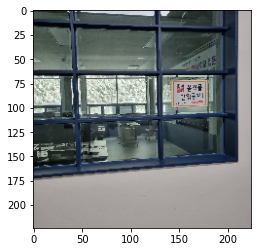

img (10).jpg : 우측 입출구1


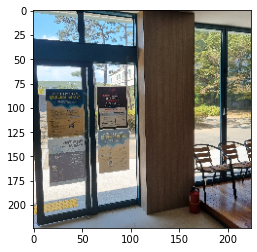

img (11).jpg : 우측 입출구1


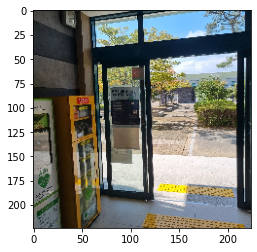

img (12).jpg : 우측 입출구1


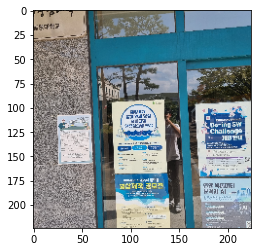

img (13).jpg : 우측 입출구1


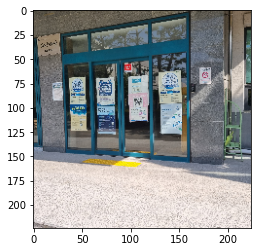

img (14).jpg : 남자 화장실


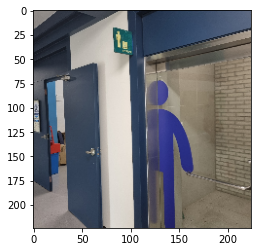

img (15).jpg : 남자 화장실


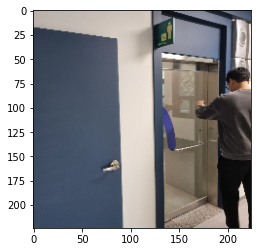

img (16).jpg : TU융합데이터 허브실


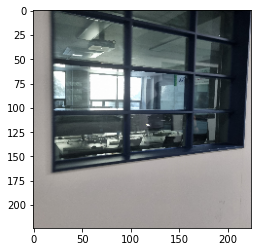

img (17).jpg : 고성능 인공지능 실험실


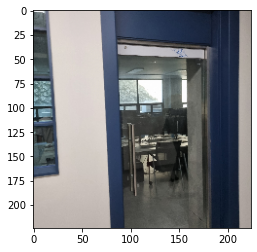

img (18).jpg : 우측 휴식처


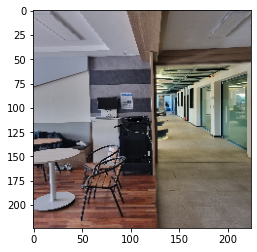

img (19).jpg : TU융합데이터 허브실


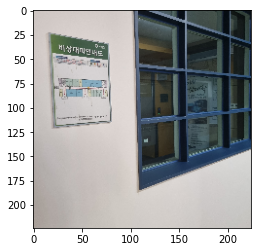

img (2).jpg : 우측 입출구1


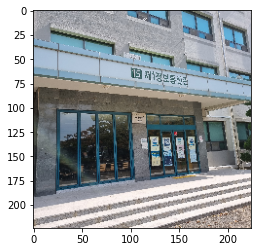

img (20).jpg : 좌측 데스크1


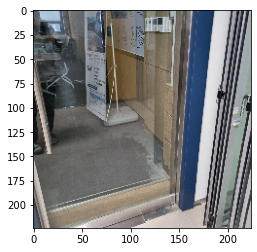

img (21).jpg : 창업동아리실


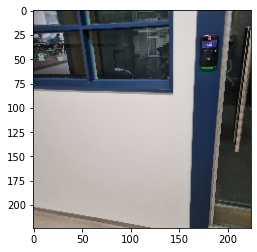

img (22).jpg : 엘리베이터


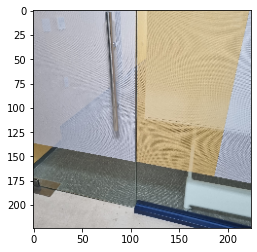

img (23).jpg : 코딩 클리닉실


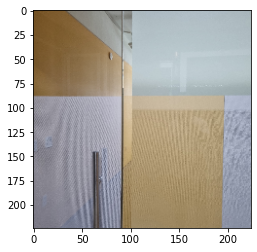

img (24).jpg : 산악협력 회의실


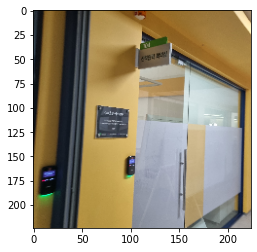

img (25).jpg : 엘리베이터


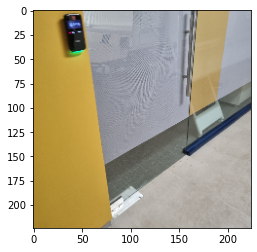

img (26).jpg : 창업동아리실


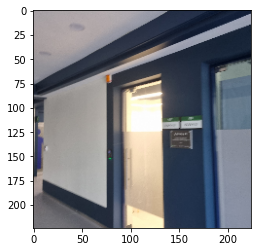

img (27).jpg : 창업동아리실


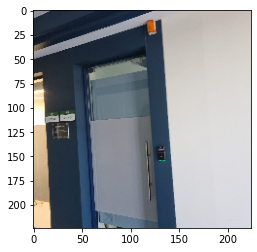

img (3).jpg : 창업동아리실


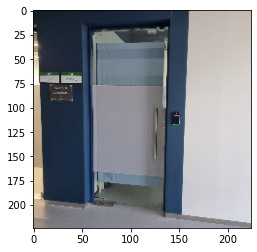

img (4).jpg : 창업동아리실


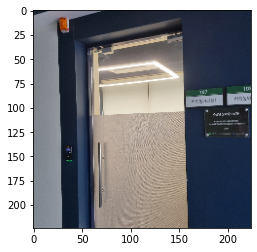

img (5).jpg : 고성능 인공지능 실험실


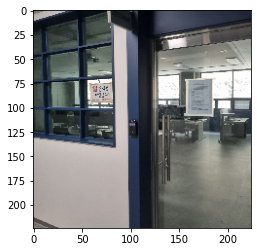

img (6).jpg : 좌측 입출구2


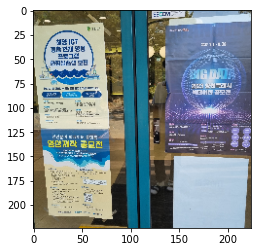

img (7).jpg : 좌측 입출구2


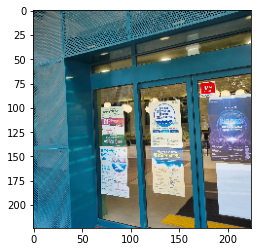

img (8).jpg : 좌측 입출구2


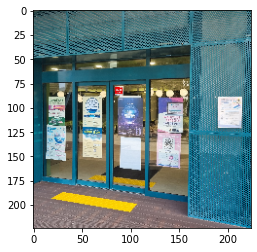

img (9).jpg : 좌측 입출구1


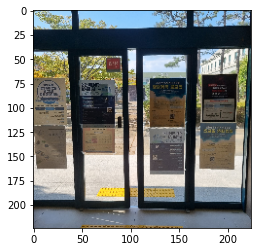

In [21]:
for i, img in enumerate(image_test2):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    print(title_list[i])
    plt.show()

In [26]:
# 모델 저장
model_name = "mobileNet_15_place_2023_11_20_2.h5"
model_model_s.save(model_name)

In [27]:
# 저장된 모델 가져오기
keras_model = tf.keras.models.load_model(model_name)

# Convert를 사용해 .h5 -> .tflite 변환
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# TFLite로 저장
tfmodel_name = 'mobileNet_23_11_20_1.tflite'
with open(tfmodel_name, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpu42rkr78\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpu42rkr78\assets
